# Proyecto de Clasificación "New vs Used" en Mercado Libre

**Objetivo del Proyecto:**
Desarrollar un modelo de Machine Learning capaz de predecir si un producto listado en Mercado Libre es "new" o "used", garantizando una accuracy mínima del 86%.

In [3]:
# Importamos librerias necesarias para el análisis y visualización de datos

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
import json
import pprint
from collections import defaultdict
import numpy as np
from sklearn.preprocessing import OneHotEncoder, LabelEncoder
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import MinMaxScaler


In [4]:
# Definimos una función para construir el dataset

def build_dataset():
    data = [json.loads(x) for x in open("../Raw_data/MLA_100k_checked_v3.jsonlines")]
    target = lambda x: x.get("condition")
    N = -10000
    X_train = data[:N]
    X_test = data[N:]
    y_train = [target(x) for x in X_train]
    y_test = [target(x) for x in X_test]
    for x in X_test:
        del x["condition"]
    return X_train, y_train, X_test, y_test


if __name__ == "__main__":
    print("Loading dataset...")
    # Train and test data following sklearn naming conventions
    # X_train (X_test too) is a list of dicts with information about each item.
    # y_train (y_test too) contains the labels to be predicted (new or used).
    # The label of X_train[i] is y_train[i].
    # The label of X_test[i] is y_test[i].
    X_train, y_train, X_test, y_test = build_dataset()

Loading dataset...


## 1 - Revision general del dataset X_train

In [5]:
pprint.pprint(X_train[0])

{'accepts_mercadopago': True,
 'attributes': [],
 'automatic_relist': False,
 'available_quantity': 1,
 'base_price': 80.0,
 'buying_mode': 'buy_it_now',
 'catalog_product_id': None,
 'category_id': 'MLA126406',
 'condition': 'new',
 'coverage_areas': [],
 'currency_id': 'ARS',
 'date_created': '2015-09-05T20:42:53.000Z',
 'deal_ids': [],
 'descriptions': ["{'id': 'MLA4695330653-912855983'}"],
 'differential_pricing': None,
 'id': 'MLA4695330653',
 'initial_quantity': 1,
 'international_delivery_mode': 'none',
 'last_updated': '2015-09-05T20:42:58.000Z',
 'listing_source': '',
 'listing_type_id': 'bronze',
 'non_mercado_pago_payment_methods': [{'description': 'Transferencia bancaria',
                                       'id': 'MLATB',
                                       'type': 'G'},
                                      {'description': 'Acordar con el '
                                                      'comprador',
                                       'id': 'MLAWC',
      

In [6]:
# Aplanar los diccionarios y convertir a DataFrame (tiene campos anidados y listas)

import json
from datetime import datetime, UTC
from dateutil.parser import parse

def flatten_item_full(item, prefix=''):
    """
    Aplana un dict arbitrariamente anidado:
    - Los dicts se descomponen en subcolumnas prefix_key.
    - Las listas se guardan en JSON-string y su longitud en prefix_key_count.
    - Los valores atómicos se copian directamente.
    """
    flat = {}
    for key, val in item.items():
        col = f"{prefix}{key}" if not prefix else f"{prefix}_{key}"

        # 1) Si es un dict, recursión
        if isinstance(val, dict):
            flat.update(flatten_item_full(val, prefix=col))
        
        # 2) Si es una lista, guardo JSON + longitud
        elif isinstance(val, list):
            # guardo la lista completa como texto JSON
            flat[col] = json.dumps(val, ensure_ascii=False)
            # guardo la longitud para modelado numérico
            flat[f"{col}_count"] = len(val)
        
        # 3) Fecha especial?
        elif key in ('date_created', 'start_time', 'stop_time', 'last_updated'):
            raw = val
            try:
                if isinstance(raw, (int, float)):
                    dt = datetime.fromtimestamp(raw/1000, tz=UTC)
                elif isinstance(raw, str) and raw.isdigit():
                    dt = datetime.fromtimestamp(int(raw)/1000, tz=UTC)
                elif isinstance(raw, str):
                    dt = parse(raw)
                    # si parse no da tz-aware, agregamos UTC
                    if dt.tzinfo is None:
                        dt = dt.replace(tzinfo=UTC)
                else:
                    dt = None

                if dt:
                    # guardo la fecha original en ISO y la antigüedad
                    flat[col] = dt.isoformat()
                    flat[f"{col}_days_since"] = (datetime.now(UTC) - dt).days
                else:
                    flat[col] = None
                    flat[f"{col}_days_since"] = None
            except:
                flat[col] = None
                flat[f"{col}_days_since"] = None
        
        # 4) Valores atómicos simples
        else:
            flat[col] = val

    return flat


# Convertimos a DataFrame
flat_records = [flatten_item_full(x) for x in X_train]
df_full = pd.DataFrame(flat_records)

# Añadimos la columna target
df_full["condition"] = y_train

print(df_full.shape)
display(df_full.head())


(90000, 72)


,seller_address_country_name,seller_address_country_id,seller_address_state_name,seller_address_state_id,seller_address_city_name,seller_address_city_id,warranty,sub_status,sub_status_count,condition,...,catalog_product_id,subtitle,initial_quantity,start_time,start_time_days_since,permalink,sold_quantity,available_quantity,shipping_free_methods,shipping_free_methods_count
0,Argentina,AR,Capital Federal,AR-C,San Cristóbal,TUxBQlNBTjkwNTZa,None,[],0,new,...,NaN,None,1,2015-09-05T20:42:53+00:00,3620,http://articulo.mercadolibre.com.ar/MLA4695330...,0,1,NaN,NaN
1,Argentina,AR,Capital Federal,AR-C,Buenos Aires,,NUESTRA REPUTACION,[],0,used,...,NaN,None,1,2015-09-26T18:08:30+00:00,3599,http://articulo.mercadolibre.com.ar/MLA7160447...,0,1,NaN,NaN
2,Argentina,AR,Capital Federal,AR-C,Boedo,TUxBQkJPRTQ0OTRa,None,[],0,used,...,NaN,None,1,2015-09-09T23:57:07+00:00,3616,http://articulo.mercadolibre.com.ar/MLA7367189...,0,1,NaN,NaN
3,Argentina,AR,Capital Federal,AR-C,Floresta,TUxBQkZMTzg5MjFa,None,[],0,new,...,NaN,None,1,2015-09-28T18:47:56+00:00,3597,http://articulo.mercadolibre.com.ar/MLA9191625...,0,1,NaN,NaN
4,Argentina,AR,Buenos Aires,AR-B,Tres de febrero,TUxBQ1RSRTMxODE5NA,MI REPUTACION.,[],0,used,...,NaN,None,1,2015-08-24T22:07:20+00:00,3632,http://articulo.mercadolibre.com.ar/MLA7787961...,0,1,NaN,NaN


In [7]:
# exportar el DataFrame a un excel
# df_full.to_excel("MLA_100k_flattened.xlsx", index=False)

In [8]:
# Listamos las 72 columnas con sus nombres

columns_list = df_full.columns.tolist()
print("Columnas del DataFrame:", len(columns_list))
print("Lista de columnas:")
for col in columns_list:
    print("-", col)

Columnas del DataFrame: 72
Lista de columnas:
- seller_address_country_name
- seller_address_country_id
- seller_address_state_name
- seller_address_state_id
- seller_address_city_name
- seller_address_city_id
- warranty
- sub_status
- sub_status_count
- condition
- deal_ids
- deal_ids_count
- base_price
- shipping_local_pick_up
- shipping_methods
- shipping_methods_count
- shipping_tags
- shipping_tags_count
- shipping_free_shipping
- shipping_mode
- shipping_dimensions
- non_mercado_pago_payment_methods
- non_mercado_pago_payment_methods_count
- seller_id
- variations
- variations_count
- site_id
- listing_type_id
- price
- attributes
- attributes_count
- buying_mode
- tags
- tags_count
- listing_source
- parent_item_id
- coverage_areas
- coverage_areas_count
- category_id
- descriptions
- descriptions_count
- last_updated
- last_updated_days_since
- international_delivery_mode
- pictures
- pictures_count
- id
- official_store_id
- differential_pricing
- accepts_mercadopago
- origina

## 1.1 Creamos nuevo DataFrame con las columnas que nos interesan para el analisis
- En Diccionario de datos / Diccionarios / Pestaña "Diccionario_0", se puede ver en detalle la justificacion de la decision de inclusion o no de cada variable

In [9]:
# Hacemos una lista con las 32 columnas que nos interesan para el modelo

desired_cols = [
    "warranty",
    "condition",
    "deal_ids",
    "base_price",
    "shipping_local_pick_up",
    "shipping_free_shipping",
    "non_mercado_pago_payment_methods",
    "seller_id",
    "listing_type_id",
    "price",
    "buying_mode",
    "tags",
    "category_id",
    "descriptions",
    "last_updated",
    "last_updated_days_since",
    "official_store_id",
    "accepts_mercadopago",
    "original_price",
    "currency_id",
    "title",
    "id",
    "automatic_relist",
    "date_created",
    "date_created_days_since",
    "stop_time",
    "stop_time_days_since",
    "initial_quantity",
    "start_time",
    "start_time_days_since",
    "sold_quantity",
    "available_quantity"
]

# 2. Comprobación de existencia de columnas
missing = [c for c in desired_cols if c not in df_full.columns]
if missing:
    raise KeyError(f"Faltan columnas en df_full: {missing}")

# 3. Cálculo y reporte de métricas de calidad para cada columna
report = []
total = len(df_full)
for col in desired_cols:
    non_null = df_full[col].notnull().sum()
    pct_present = non_null / total
    n_unique = df_full[col].nunique(dropna=False)
    report.append({
        "columna": col,
        "pct_present": pct_present,
        "n_unique": n_unique,
        "tipo": df_full[col].dtype
    })

df_report = pd.DataFrame(report).set_index("columna")
display(df_report)

# 4. Criterios de aceptación:
#    - Al menos 5% de no-nulos para columnas críticas
#    - Al menos 2 valores únicos para evitar constantes
accepted = df_report[
    (df_report["pct_present"] >= 0.05) &    # cobertura mínima
    (df_report["n_unique"] > 1)            # variabilidad mínima
].index.tolist()

print("Columnas que cumplen cobertura >5% y >1 valor único:", len(accepted))
print(accepted)

# 5. Selección final 
#    Incluimos manualmente warranty, original_price, official_store_id incluso si tienen baja cobertura,
#    por su psible correlacion con la condition.
final_cols = [
    c for c in accepted 
    if c not in ("warranty", "original_price","official_store_id")
] + ["warranty", "original_price","official_store_id"]

# Mantenemos orden original
final_cols = [c for c in desired_cols if c in final_cols]

# 6. Creamos df_train con las columnas refinadas
df_train = df_full[final_cols].copy()
print("\n>> Shape final de df_train:", df_train.shape)
display(df_train.head())


,pct_present,n_unique,tipo
columna,,,
warranty,0.391589,9537,object
condition,1.000000,2,object
deal_ids,1.000000,31,object
base_price,1.000000,9594,float64
shipping_local_pick_up,1.000000,2,bool
shipping_free_shipping,1.000000,2,bool
non_mercado_pago_payment_methods,1.000000,174,object
seller_id,1.000000,33281,int64
listing_type_id,1.000000,7,object


Columnas que cumplen cobertura >5% y >1 valor único: 30
['warranty', 'condition', 'deal_ids', 'base_price', 'shipping_local_pick_up', 'shipping_free_shipping', 'non_mercado_pago_payment_methods', 'seller_id', 'listing_type_id', 'price', 'buying_mode', 'tags', 'category_id', 'descriptions', 'last_updated', 'last_updated_days_since', 'accepts_mercadopago', 'currency_id', 'title', 'id', 'automatic_relist', 'date_created', 'date_created_days_since', 'stop_time', 'stop_time_days_since', 'initial_quantity', 'start_time', 'start_time_days_since', 'sold_quantity', 'available_quantity']

>> Shape final de df_train: (90000, 32)


,warranty,condition,deal_ids,base_price,shipping_local_pick_up,shipping_free_shipping,non_mercado_pago_payment_methods,seller_id,listing_type_id,price,...,automatic_relist,date_created,date_created_days_since,stop_time,stop_time_days_since,initial_quantity,start_time,start_time_days_since,sold_quantity,available_quantity
0,None,new,[],80.0,True,False,"[{""description"": ""Transferencia bancaria"", ""id...",8208882349,bronze,80.0,...,False,2015-09-05T20:42:53+00:00,3620,2015-11-04T20:42:53+00:00,3560,1,2015-09-05T20:42:53+00:00,3620,0,1
1,NUESTRA REPUTACION,used,[],2650.0,True,False,"[{""description"": ""Transferencia bancaria"", ""id...",8141699488,silver,2650.0,...,False,2015-09-26T18:08:30+00:00,3599,2015-11-25T18:08:30+00:00,3539,1,2015-09-26T18:08:30+00:00,3599,0,1
2,None,used,[],60.0,True,False,"[{""description"": ""Transferencia bancaria"", ""id...",8386096505,bronze,60.0,...,False,2015-09-09T23:57:07+00:00,3616,2015-11-08T23:57:07+00:00,3556,1,2015-09-09T23:57:07+00:00,3616,0,1
3,None,new,[],580.0,True,False,"[{""description"": ""Transferencia bancaria"", ""id...",5377752182,silver,580.0,...,False,2015-09-28T18:47:56+00:00,3597,2015-12-04T01:13:16+00:00,3531,1,2015-09-28T18:47:56+00:00,3597,0,1
4,MI REPUTACION.,used,[],30.0,True,False,"[{""description"": ""Transferencia bancaria"", ""id...",2938071313,bronze,30.0,...,False,2015-08-24T22:07:20+00:00,3632,2015-10-23T22:07:20+00:00,3572,1,2015-08-24T22:07:20+00:00,3632,0,1


In [10]:
# pasar df_train a un archivo excel
# df_train.to_excel("MLA_100k_tra.xlsx", index=False)

In [11]:
# elimina la columna deal_ids_count
df_train.drop(columns=["deal_ids_count"], inplace=True, errors='ignore')

In [12]:
# Dimensiones del dataset
print("shape", df_train.shape)

# Primeras filas
display(df_train.head())

shape (90000, 32)


,warranty,condition,deal_ids,base_price,shipping_local_pick_up,shipping_free_shipping,non_mercado_pago_payment_methods,seller_id,listing_type_id,price,...,automatic_relist,date_created,date_created_days_since,stop_time,stop_time_days_since,initial_quantity,start_time,start_time_days_since,sold_quantity,available_quantity
0,None,new,[],80.0,True,False,"[{""description"": ""Transferencia bancaria"", ""id...",8208882349,bronze,80.0,...,False,2015-09-05T20:42:53+00:00,3620,2015-11-04T20:42:53+00:00,3560,1,2015-09-05T20:42:53+00:00,3620,0,1
1,NUESTRA REPUTACION,used,[],2650.0,True,False,"[{""description"": ""Transferencia bancaria"", ""id...",8141699488,silver,2650.0,...,False,2015-09-26T18:08:30+00:00,3599,2015-11-25T18:08:30+00:00,3539,1,2015-09-26T18:08:30+00:00,3599,0,1
2,None,used,[],60.0,True,False,"[{""description"": ""Transferencia bancaria"", ""id...",8386096505,bronze,60.0,...,False,2015-09-09T23:57:07+00:00,3616,2015-11-08T23:57:07+00:00,3556,1,2015-09-09T23:57:07+00:00,3616,0,1
3,None,new,[],580.0,True,False,"[{""description"": ""Transferencia bancaria"", ""id...",5377752182,silver,580.0,...,False,2015-09-28T18:47:56+00:00,3597,2015-12-04T01:13:16+00:00,3531,1,2015-09-28T18:47:56+00:00,3597,0,1
4,MI REPUTACION.,used,[],30.0,True,False,"[{""description"": ""Transferencia bancaria"", ""id...",2938071313,bronze,30.0,...,False,2015-08-24T22:07:20+00:00,3632,2015-10-23T22:07:20+00:00,3572,1,2015-08-24T22:07:20+00:00,3632,0,1


### 1.2 Recortamos campos del df_train
- En Diccionario de datos / Diccionarios / Pestaña "Diccionario_1" y "Diccionario_2", se puede ver en detalle la justificacion de la decision de inclusion o no de cada variable

In [13]:

clean_cols = [
    "condition",
    "base_price",
    "seller_id",
    "listing_type_id",
    "price",
    "buying_mode",
    "category_id",
    "descriptions",
    "official_store_id",
    "original_price",
    "title",
    "id",
    "date_created_days_since",
    "sold_quantity"
]

df_clean = df_train[clean_cols].copy()
print("Shape de df_clean:", df_clean.shape)
display(df_clean.head())

Shape de df_clean: (90000, 14)


,condition,base_price,seller_id,listing_type_id,price,buying_mode,category_id,descriptions,official_store_id,original_price,title,id,date_created_days_since,sold_quantity
0,new,80.0,8208882349,bronze,80.0,buy_it_now,MLA126406,"[""{'id': 'MLA4695330653-912855983'}""]",NaN,NaN,Auriculares Samsung Originales Manos Libres Ca...,MLA4695330653,3620,0
1,used,2650.0,8141699488,silver,2650.0,buy_it_now,MLA10267,"[""{'id': 'MLA7160447179-930764806'}""]",NaN,NaN,Cuchillo Daga Acero Carbón Casco Yelmo Solinge...,MLA7160447179,3599,0
2,used,60.0,8386096505,bronze,60.0,buy_it_now,MLA1227,"[""{'id': 'MLA7367189936-916478256'}""]",NaN,NaN,"Antigua Revista Billiken, N° 1826, Año 1954",MLA7367189936,3616,0
3,new,580.0,5377752182,silver,580.0,buy_it_now,MLA86345,"[""{'id': 'MLA9191625553-932309698'}""]",NaN,NaN,Alarma Guardtex Gx412 Seguridad Para El Automo...,MLA9191625553,3597,0
4,used,30.0,2938071313,bronze,30.0,buy_it_now,MLA41287,"[""{'id': 'MLA7787961817-902981678'}""]",NaN,NaN,Serenata - Jennifer Blake,MLA7787961817,3632,0


In [14]:
# Tipos de datos 
display(df_clean.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 90000 entries, 0 to 89999
Data columns (total 14 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   condition                90000 non-null  object 
 1   base_price               90000 non-null  float64
 2   seller_id                90000 non-null  int64  
 3   listing_type_id          90000 non-null  object 
 4   price                    90000 non-null  float64
 5   buying_mode              90000 non-null  object 
 6   category_id              90000 non-null  object 
 7   descriptions             90000 non-null  object 
 8   official_store_id        745 non-null    float64
 9   original_price           130 non-null    float64
 10  title                    90000 non-null  object 
 11  id                       90000 non-null  object 
 12  date_created_days_since  90000 non-null  int64  
 13  sold_quantity            90000 non-null  int64  
dtypes: float64(4), int64(3

None

In [15]:
#valores nulos
display(df_clean.isnull().sum().sort_values(ascending=False))

original_price             89870
official_store_id          89255
condition                      0
base_price                     0
seller_id                      0
listing_type_id                0
price                          0
buying_mode                    0
category_id                    0
descriptions                   0
title                          0
id                             0
date_created_days_since        0
sold_quantity                  0
dtype: int64

In [16]:
# Distribución de la variable objetivo. Importante saber si las clases están balanceadas. Influye en la metrica y el tipo de muestreo 

print("\nDistribución de la variable objetivo:")
print(df_clean["condition"].value_counts())
print(df_clean["condition"].value_counts(normalize=True)) 


Distribución de la variable objetivo:
condition
new     48352
used    41648
Name: count, dtype: int64
condition
new     0.537244
used    0.462756
Name: proportion, dtype: float64


## 2. Pre-Procesado de Dataset
- Total de registros: 90,000
- Variables seleccionadas tras limpieza: 14 principales + TF-IDF del título (reducidos a componentes significativos)
- Variables eliminadas: URLs, imágenes, campos redundantes, IDs triviales y variables con valores constantes o leaks.

In [17]:
# Guardamos una copia del DataFrame limpio para futuras referencias
df = df_clean.copy()

# 1. ID - para trazabilidad
df_id = df['id']  
df = df.drop(columns=['id']) 

# 2. condition - Solo para EDA, no modelado
df_condition = df['condition'] 


In [18]:
# 3. seller_id - Count Encoding (Cantidad de publicaciones por seller)

seller_counts = df['seller_id'].value_counts().to_dict()
df['seller_publications'] = df['seller_id'].map(seller_counts)  
df = df.drop(columns=['seller_id']) 

In [19]:
# 4. listing_type_id - One-Hot Encoding

listing_type_ohe = pd.get_dummies(df['listing_type_id'], prefix='listing_type')
df = pd.concat([df.drop(columns=['listing_type_id']), listing_type_ohe], axis=1)

In [20]:
# 5. buying_mode - One-Hot Encoding

buying_mode_ohe = pd.get_dummies(df['buying_mode'], prefix='buying_mode')
df = pd.concat([df.drop(columns=['buying_mode']), buying_mode_ohe], axis=1)

In [21]:
# 6. category_id - Frequency Encoding (Proporción de publicaciones por categoría)

category_freq = df['category_id'].value_counts(normalize=True).to_dict()
df['category_freq'] = df['category_id'].map(category_freq)
df = df.drop(columns=['category_id'])

In [22]:
# 7. official_store_id - Boolean (es tienda oficial: 1 / 0)

df['is_official_store'] = df['official_store_id'].apply(lambda x: 0 if pd.isna(x) else 1)
df = df.drop(columns=['official_store_id'])

In [23]:
# 8. Detectar "usado" en title y crear feature booleana

df['has_used_in_title'] = df['title'].str.lower().str.contains('usado').astype(int)

In [24]:
# 8. descriptions - NLP básica (TF-IDF Vectorizer)
# esta transformación convierte el texto de las descripciones en una representación numérica que captura la importancia de cada palabra en el contexto del conjunto de datos.
# sirve para que el modelo pueda entender el contenido textual de las descripciones y aprender patrones relevantes para la predicción de la variable objetivo.

df['description_length'] = df['descriptions'].apply(lambda x: len(str(x)))
df['description_word_count'] = df['descriptions'].apply(lambda x: len(str(x).split()))

In [25]:
# esta transformación crea una matriz de características donde cada fila representa un ítem y cada columna una palabra importante.
# El valor en cada celda indica la importancia de esa palabra en el contexto del ítem
# esto permite que el modelo aprenda patrones relevantes en el texto de las descripciones, mejorando su capacidad para predecir la variable objetivo.

tfidf_desc = TfidfVectorizer(max_features=100)
desc_tfidf_matrix = tfidf_desc.fit_transform(df['descriptions'].fillna(''))
desc_tfidf_df = pd.DataFrame(desc_tfidf_matrix.toarray(), columns=[f'desc_tfidf_{i}' for i in range(desc_tfidf_matrix.shape[1])])
df = pd.concat([df, desc_tfidf_df], axis=1)
df = df.drop(columns=['descriptions'])

In [26]:
# 9. title - NLP básica (TF-IDF Vectorizer)

df['title_length'] = df['title'].apply(lambda x: len(str(x)))
df['title_word_count'] = df['title'].apply(lambda x: len(str(x).split()))

# TF-IDF Vectorizer (simple - unigrams, max_features=100)

tfidf_title = TfidfVectorizer(max_features=100)
title_tfidf_matrix = tfidf_title.fit_transform(df['title'].fillna(''))
title_tfidf_df = pd.DataFrame(title_tfidf_matrix.toarray(), columns=[f'title_tfidf_{i}' for i in range(title_tfidf_matrix.shape[1])])
df = pd.concat([df, title_tfidf_df], axis=1)
df = df.drop(columns=['title'])

In [27]:

# 10. base_price, price, original_price, sold_quantity, date_created_days_since - Scaling
# esta transformacion es útil para que las variables numéricas tengan una escala similar, lo que mejora la convergencia de los algoritmos de optimización y evita que variables con rangos más amplios dominen el modelo.
# La normalización asegura que todas las variables contribuyan de manera equitativa al modelo

scaler = MinMaxScaler()
df[['base_price', 'price', 'original_price', 'sold_quantity', 'date_created_days_since']] = scaler.fit_transform(df[['base_price', 'price', 'original_price', 'sold_quantity', 'date_created_days_since']])


In [28]:
# 11. Dataset fianl para el EDA
df_transformed = df.copy()

In [29]:
df_transformed.head()  # Mostrar las primeras filas del DataFrame transformado

,condition,base_price,price,original_price,date_created_days_since,sold_quantity,seller_publications,listing_type_bronze,listing_type_free,listing_type_gold,...,title_tfidf_90,title_tfidf_91,title_tfidf_92,title_tfidf_93,title_tfidf_94,title_tfidf_95,title_tfidf_96,title_tfidf_97,title_tfidf_98,title_tfidf_99
0,new,3.562200e-08,3.562200e-08,NaN,0.045610,0.0,1,True,False,False,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.531575,0.0,0.0
1,used,1.192122e-06,1.192122e-06,NaN,0.021665,0.0,2,False,False,False,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0
2,used,2.662200e-08,2.662200e-08,NaN,0.041049,0.0,31,True,False,False,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0
3,new,2.606220e-07,2.606220e-07,NaN,0.019384,0.0,4,False,False,False,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0
4,used,1.312200e-08,1.312200e-08,NaN,0.059293,0.0,76,True,False,False,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0


### 2.1 PERFIL ESTADISTICO DE DF_TRANSFORMED

In [30]:
df = df_transformed.copy()

# Tipos de datos 

display(df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 90000 entries, 0 to 89999
Columns: 224 entries, condition to title_tfidf_99
dtypes: bool(10), float64(206), int32(1), int64(6), object(1)
memory usage: 147.5+ MB


None

In [31]:
#valores nulos

display(df.isnull().sum().sort_values(ascending=False))

original_price    89870
condition             0
title_tfidf_30        0
title_tfidf_19        0
title_tfidf_20        0
                  ...  
desc_tfidf_57         0
desc_tfidf_58         0
desc_tfidf_59         0
desc_tfidf_60         0
title_tfidf_99        0
Length: 224, dtype: int64

In [32]:
# Distribución de la variable objetivo.

print("\nDistribución de la variable objetivo:")
print(df["condition"].value_counts())
print(df["condition"].value_counts(normalize=True))  # proporciones


Distribución de la variable objetivo:
condition
new     48352
used    41648
Name: count, dtype: int64
condition
new     0.537244
used    0.462756
Name: proportion, dtype: float64


In [33]:
# Check columnas constantes. Para evitar problemas en el modelado, es importante identificar y eliminar columnas que no aportan información útil, como aquellas con un único valor constante.

print("\nColumnas constantes:\n")
constant_cols = [col for col in df.columns if df[col].nunique() == 1]
print(constant_cols)


Columnas constantes:

[]


In [34]:
# Distribución de las boolean features.

bool_features = [col for col in df.columns if set(df[col].unique()) <= {0,1}]
print("\nDistribucion de Boolean Features:\n")
for col in bool_features:
    print(f"{col} --> {df[col].value_counts().to_dict()}")


Distribucion de Boolean Features:

listing_type_bronze --> {True: 56904, False: 33096}
listing_type_free --> {False: 70740, True: 19260}
listing_type_gold --> {False: 87830, True: 2170}
listing_type_gold_premium --> {False: 89235, True: 765}
listing_type_gold_pro --> {False: 89987, True: 13}
listing_type_gold_special --> {False: 87307, True: 2693}
listing_type_silver --> {False: 81805, True: 8195}
buying_mode_auction --> {False: 89293, True: 707}
buying_mode_buy_it_now --> {True: 87311, False: 2689}
buying_mode_classified --> {False: 88018, True: 1982}
is_official_store --> {0: 89255, 1: 745}
has_used_in_title --> {0: 89484, 1: 516}


# 3. Análisis Exploratorio de Datos (EDA)

- Objetivo del EDA: Analizar y comprender las variables del dataset para identificar patrones, inconsistencias, relaciones y características que puedan influir en la clasificación del estado de un producto ('new' o 'used').

## Dataset Pre-Procesado
- Total de registros: 90,000
- Variables seleccionadas tras limpieza: 14 principales + TF-IDF del título
- Variables eliminadas: URLs, imágenes, campos redundantes, IDs triviales y variables con valores constantes o leaks.

In [35]:

df = df_transformed.copy()
df['condition'] = df_condition  # Añadimos la variable target para el EDA

## 3. Análisis Univariado

### 3.1 Variable Target - Condition
- Distribución: 54% 'new', 46% 'used'.
- Balance adecuado para clasificación.

El dataset presenta una distribución razonablemente balanceada entre productos 'new' y 'used' (54%-46%), lo que permite abordar la clasificación sin necesidad de técnicas de rebalanceo.

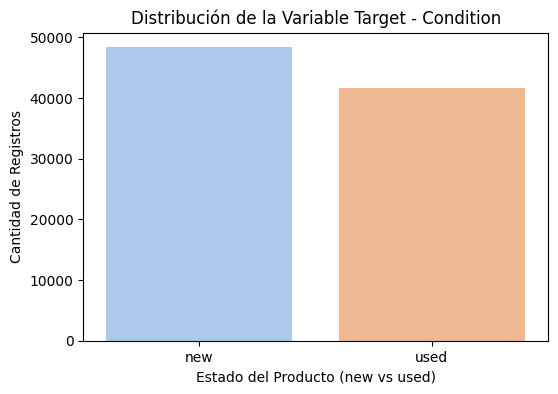

In [36]:
# 1. Análisis Univariado - Distribución de la Variable Target (condition)
# Objetivo: entender si el dataset está balanceado entre las clases "new" y "used".
# Si las clases están desbalanceadas, puede ser necesario aplicar técnicas de balanceo en el modelado.

plt.figure(figsize=(6,4))
sns.countplot(data=df, x='condition', hue='condition', palette='pastel', legend=False)
plt.title('Distribución de la Variable Target - Condition')
plt.xlabel('Estado del Producto (new vs used)')
plt.ylabel('Cantidad de Registros')
plt.show()

### 3.2 has_used_in_title
- Variable booleana que indica si el título contiene la palabra "usado".
- Insight: Aunque es una variable con alta precisión (cuando está en 1 suele ser un “used”), su recall es bajo (solo capta a unos pocos usados).


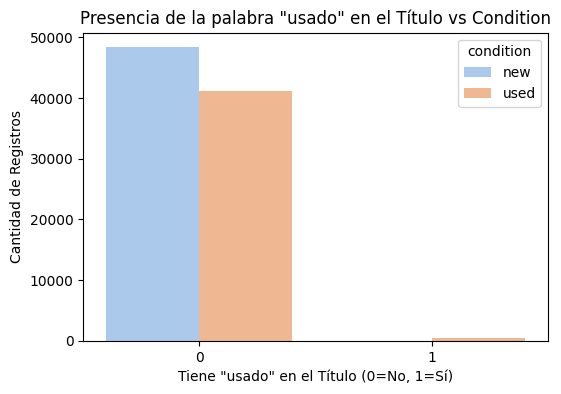

In [37]:
# 2. Análisis Univariado - Variable Booleana has_used_in_title
# Objetivo: Analizar cuántas publicaciones mencionan explícitamente la palabra "usado" en el título. Esto puede ser un fuerte indicador de la condición real.
plt.figure(figsize=(6,4))
sns.countplot(data=df, x='has_used_in_title', hue='condition', palette='pastel')
plt.title('Presencia de la palabra "usado" en el Título vs Condition')
plt.xlabel('Tiene "usado" en el Título (0=No, 1=Sí)')
plt.ylabel('Cantidad de Registros')
plt.show()

### 3.3 sold_quantity
- Distribución altamente sesgada (skew positivo).
- La mayoría de los productos tienen ventas bajas, pero existeuna larga cola de valores outliers (picos muy altos de ventas)
- La mayoría de los productos publicados venden pocas unidades. comportamiento es esperado en marketplaces
- Evaluar la importancia de sold_quantity como predictor: es probable que productos usados tengan menor volumen de ventas.


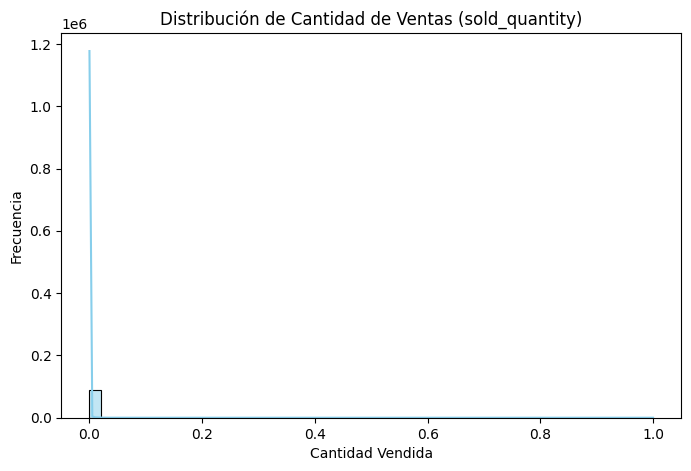

In [38]:
# 3. Análisis Univariado - Variable Numérica sold_quantity
# Objetivo: Analizar cómo se distribuye la cantidad de ventas en el dataset. Puede haber sesgos por productos muy vendidos.
plt.figure(figsize=(8,5))
sns.histplot(df['sold_quantity'], bins=50, kde=True, color='skyblue')
plt.title('Distribución de Cantidad de Ventas (sold_quantity)')
plt.xlabel('Cantidad Vendida')
plt.ylabel('Frecuencia')
plt.show()

In [39]:
# Creamos seller_profile_type según cantidad de publicaciones new/used por seller
# Considerando que seller_publication indica la cantidad de publicaciones por seller

df['seller_id'] = df['seller_publications']

# Calcular proporciones de publicaciones new/used por seller
seller_condition = df.groupby('seller_id')['condition'].value_counts(normalize=True).unstack().fillna(0)

# Crear el perfil del vendedor según reglas de negocio
def clasificar_vendedor(row):
    if row['new'] == 1.0:
        return 'Vende solo new'
    elif row['used'] == 1.0:
        return 'Vende solo used'
    else:
        return 'Vende mixto'

seller_condition['perfil_vendedor'] = seller_condition.apply(clasificar_vendedor, axis=1)

# Unir nuevamente al dataframe principal
df = df.merge(seller_condition['perfil_vendedor'], left_on='seller_id', right_index=True)

### 3.4 seller_profile_type vs condition
- La mayoría de las publicaciones (alrededor del 85-90%) pertenecen a vendedores mixtos (Vende mixto), es decir, aquellos que tienen listados tanto de productos “new” como “used”.
- Una porción más pequeña (alrededor del 5%) corresponde a vendedores que venden solo productos nuevos.
- Una fracción muy pequeña (menos del 1%) son vendedores que venden solo productos usados.
- Alta precision de new o used pero bajo recall



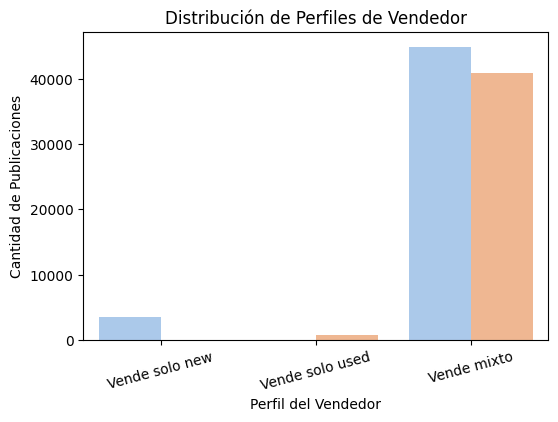

In [40]:
# 1. Análisis Univariado - Distribución de perfiles de vendedor
plt.figure(figsize=(6,4))
sns.countplot(data=df, x='perfil_vendedor', order=['Vende solo new', 'Vende solo used', 'Vende mixto'], hue='condition', palette='pastel', legend=False)
plt.title('Distribución de Perfiles de Vendedor')
plt.xlabel('Perfil del Vendedor')
plt.ylabel('Cantidad de Publicaciones')
plt.xticks(rotation=15)
plt.show()



## 4. Análisis Bivariado

### 4.1 sold_quantity vs condition
- La variable sold_quantity muestra un rango de ventas ligeramente mayor en productos “new” que en “used”.
- La mediana de ventas de ambos grupos parece estar cercana a cero ➔ la mayoría de los productos (tanto new como used) venden muy poco.
- Se observan outliers con ventas significativamente más altas:
    - En “new” hay muchos más outliers, incluso casos extremos de ventas muy altas.
    - En “used” también hay outliers, pero en menor cantidad y con valores máximos más bajos.

El análisis de sold_quantity según condición mostró que los productos nuevos tienen mayor dispersión y picos de ventas, lo que justifica usar esta variable como feature para capturar patrones de venta relacionados al estado del producto.

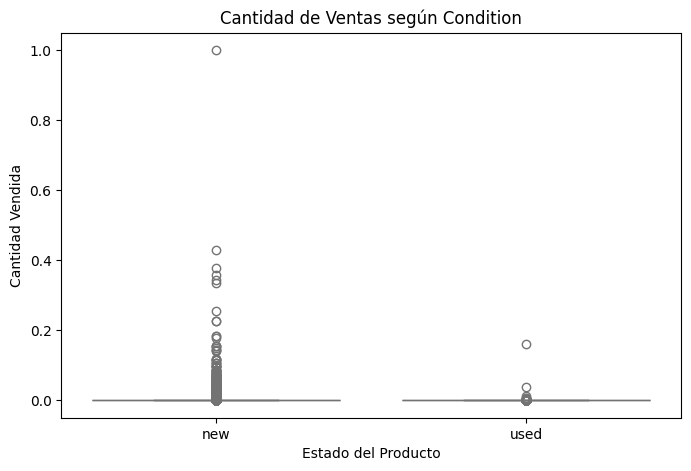

In [41]:
# 4. Análisis Bivariado - sold_quantity vs condition
# Objetivo: Comparar si los productos nuevos se venden más que los usados.
plt.figure(figsize=(8,5))
sns.boxplot(data=df, x='condition', y='sold_quantity', hue='condition', palette='pastel', legend=False)
plt.title('Cantidad de Ventas según Condition')
plt.xlabel('Estado del Producto')
plt.ylabel('Cantidad Vendida')
plt.show()

### 4.2 is_official_store vs condition
- Alta precisión: publicaciones oficiales son casi siempre "new".
- Baja cobertura en el dataset.

La variable is_official_store funciona como un indicador de alta precisión para identificar productos nuevos, dado que prácticamente la totalidad de las publicaciones dentro de tiendas oficiales son 'new'. Pero al mismo tiempo tiene un bajo recall

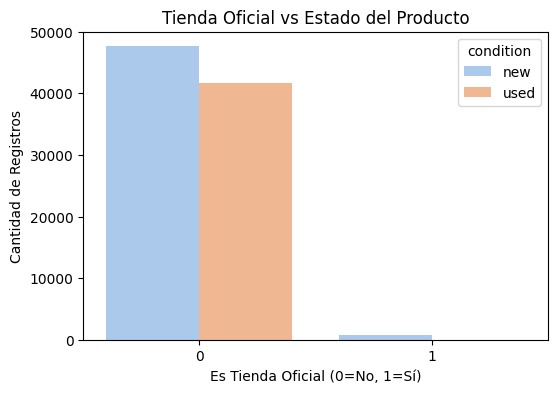

In [42]:
# 5. Análisis Bivariado - is_official_store vs condition
# Objetivo: Analizar si las tiendas oficiales venden predominantemente productos nuevos.
plt.figure(figsize=(6,4))
sns.countplot(data=df, x='is_official_store', hue='condition', palette='pastel')
plt.title('Tienda Oficial vs Estado del Producto')
plt.xlabel('Es Tienda Oficial (0=No, 1=Sí)')
plt.ylabel('Cantidad de Registros')
plt.show()


### 4.3 listing_type_id vs condition
- Tipo de publicación es un fuerte diferenciador.
- Publicaciones gratuitas (free) dominadas por productos usados.
- Publicaciones premium (gold_special, gold_pro) casi exclusivamente "new".

El tipo de publicación es un fuerte indicador del estado del producto, donde las publicaciones de mayor inversión (gold, gold_pro, gold_special) están fuertemente asociadas a productos nuevos, mientras que las gratuitas se vinculan principalmente con productos usados.

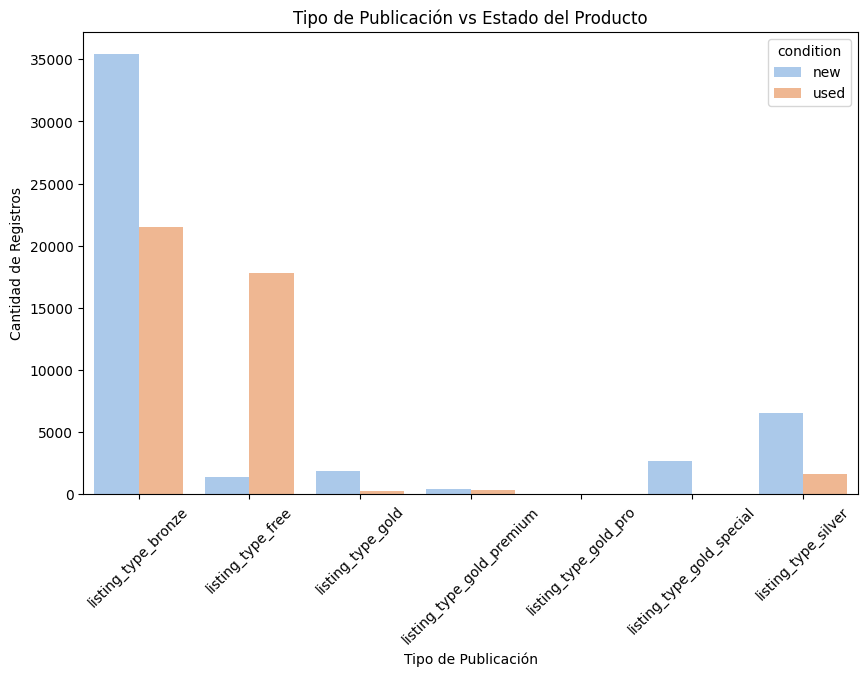

In [43]:
# 6. Análisis Bivariado - listing_type_id (One-Hot Encoded) vs condition
# Objetivo: Analizar cómo se distribuyen los tipos de publicación entre productos nuevos y usados.
listing_type_cols = [col for col in df.columns if 'listing_type_' in col]
df_listing = df.melt(id_vars='condition', value_vars=listing_type_cols, var_name='Tipo de Publicación', value_name='Presencia')
df_listing = df_listing[df_listing['Presencia'] == 1]
plt.figure(figsize=(10,6))
sns.countplot(data=df_listing, x='Tipo de Publicación', hue='condition', palette='pastel')
plt.title('Tipo de Publicación vs Estado del Producto')
plt.xticks(rotation=45)
plt.ylabel('Cantidad de Registros')
plt.show()

### 4.4 category_freq
Frecuencia relativa de la categoría en el dataset.

- Distribución similar entre productos "new" y "used"
- La variable category_freq no muestra diferencias notables entre productos “new” y “used”.
- Esto significa que productos de ambas condiciones están distribuidos de manera similar respecto a la popularidad de sus categorías.


La variable category_freq muestra una distribución muy similar entre productos nuevos y usados, indicando que la frecuencia global de una categoría no es un diferenciador fuerte del estado del producto.

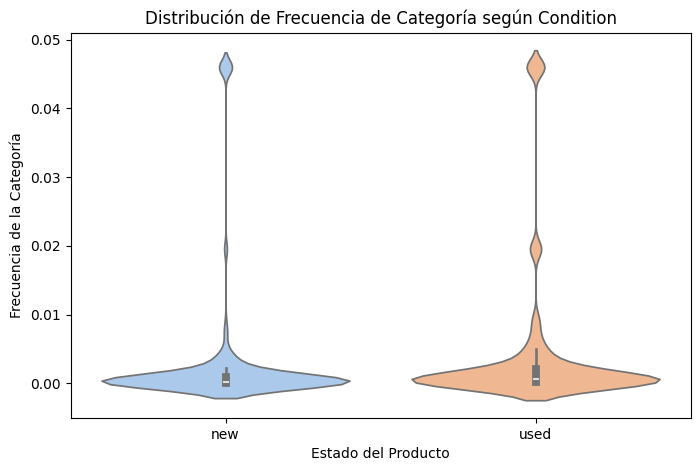

In [44]:
# 7. Análisis Bivariado - category_freq vs condition
# Objetivo: Evaluar si ciertos rubros o categorías tienden a tener más productos usados.
plt.figure(figsize=(8,5))
sns.violinplot(data=df, x='condition', y='category_freq', hue='condition', palette='pastel', legend=False)
plt.title('Distribución de Frecuencia de Categoría según Condition')
plt.xlabel('Estado del Producto')
plt.ylabel('Frecuencia de la Categoría')
plt.show()

### 4.5 base_price, price, original_price
- Objetivo: Evaluar si el precio base, publicado y original tienen comportamientos diferenciados entre nuevos y usados.
- Precios escalados con MinMaxScaler (rango 0-1).
- En general, los productos "new" presentan mayor dispersión/rango de precios mientras que "used" se encuentran en precios mas bajos.

- La variable base_price muestra una dispersión significativamente mayor en productos nuevos, con precios base que alcanzan niveles más altos. En productos usados, los precios están más concentrados en valores bajos. 

- La variable price refleja la lógica del mercado: los productos nuevos tienen precios más variados, incluso altos, mientras que los usados se concentran en precios bajos. Esta feature en combinacion con otras variables puede tener gran potencial predictivo. 

- original_price solo presente en productos "new" ➔ Su ausencia en "used" será útil para el modelo aunque deberá monitorearse en la etapa de feature importance para evitar overfitting.

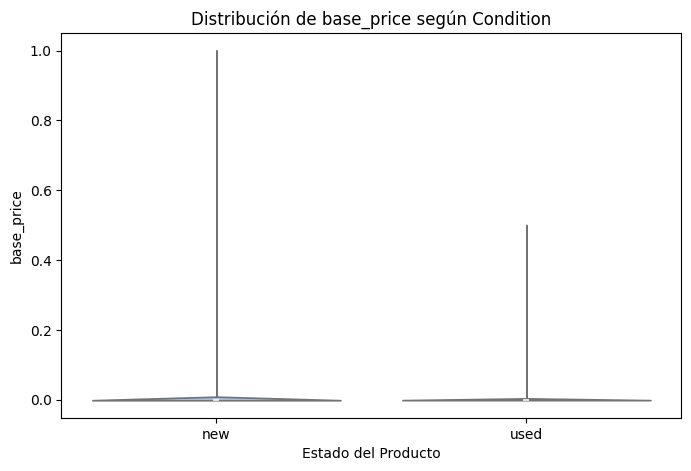

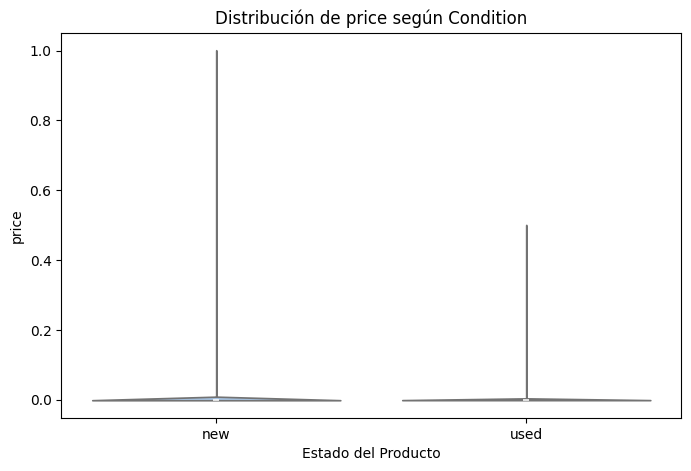

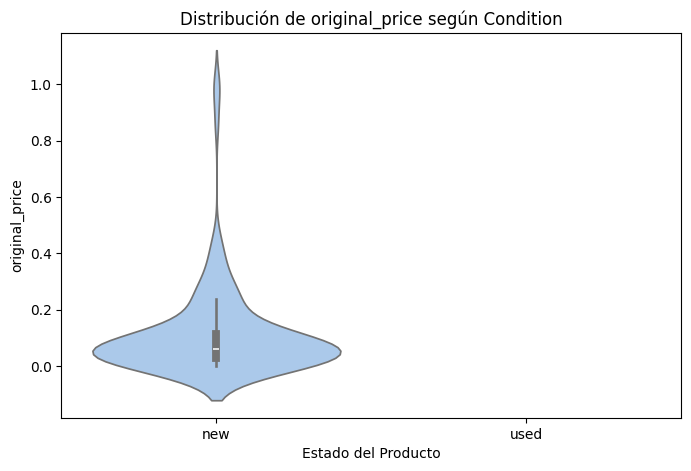

In [45]:
# 8. Análisis de Distribución - Variables de Precio
for feature in ['base_price', 'price', 'original_price']:
    plt.figure(figsize=(8,5))
    sns.violinplot(data=df, x='condition', y=feature, hue='condition', palette='pastel', legend=False)
    plt.title(f'Distribución de {feature} según Condition')
    plt.xlabel('Estado del Producto')
    plt.ylabel(feature)
    plt.show()

In [46]:
df.head()  # Mostrar las primeras filas del DataFrame transformado

,condition,base_price,price,original_price,date_created_days_since,sold_quantity,seller_publications,listing_type_bronze,listing_type_free,listing_type_gold,...,title_tfidf_92,title_tfidf_93,title_tfidf_94,title_tfidf_95,title_tfidf_96,title_tfidf_97,title_tfidf_98,title_tfidf_99,seller_id,perfil_vendedor
0,new,3.562200e-08,3.562200e-08,NaN,0.045610,0.0,1,True,False,False,...,0.0,0.0,0.0,0.0,0.0,0.531575,0.0,0.0,1,Vende mixto
1,used,1.192122e-06,1.192122e-06,NaN,0.021665,0.0,2,False,False,False,...,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,2,Vende mixto
2,used,2.662200e-08,2.662200e-08,NaN,0.041049,0.0,31,True,False,False,...,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,31,Vende mixto
3,new,2.606220e-07,2.606220e-07,NaN,0.019384,0.0,4,False,False,False,...,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,4,Vende mixto
4,used,1.312200e-08,1.312200e-08,NaN,0.059293,0.0,76,True,False,False,...,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,76,Vende mixto


### 4.6 seller_profile_type vs condition

El perfil de vendedor es muy preciso para identificar productos nuevos cuando el vendedor solo vende ‘new’. Pero su recall es bajo porque muchos productos nuevos también vienen de vendedores mixtos, donde esta variable por sí sola no alcanza.

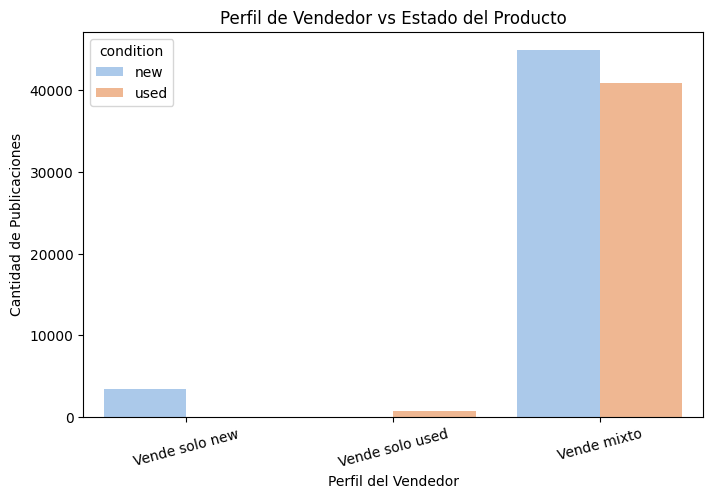

In [47]:
# 9. Análisis Bivariado - perfil_vendedor vs condition
plt.figure(figsize=(8,5))
sns.countplot(data=df, x='perfil_vendedor', hue='condition', order=['Vende solo new', 'Vende solo used', 'Vende mixto'], palette='pastel')
plt.title('Perfil de Vendedor vs Estado del Producto')
plt.xlabel('Perfil del Vendedor')
plt.ylabel('Cantidad de Publicaciones')
plt.xticks(rotation=15)
plt.show()


### 4.7 sold_quantity según seller_profile_type

El análisis de sold_quantity según perfil de vendedor demuestra que los vendedores mixtos concentran el mayor volumen de ventas, incluyendo productos de alto rendimiento (best-sellers). Los vendedores especializados en solo ‘new’ o ‘used’ presentan ventas más bajas, reflejando perfiles de menor volumen o ventas esporádicas.

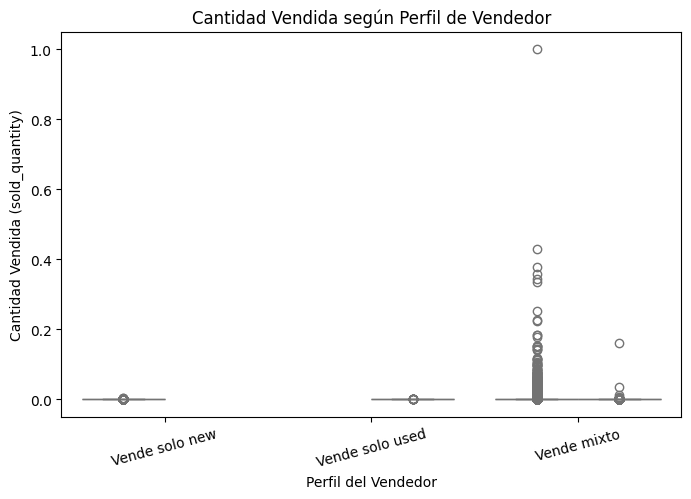

In [48]:
# 10. Análisis Bivariado - sold_quantity según perfil_vendedor
plt.figure(figsize=(8,5))
sns.boxplot(data=df, x='perfil_vendedor', y='sold_quantity', order=['Vende solo new', 'Vende solo used', 'Vende mixto'], hue='condition', palette='pastel', legend=False)
plt.title('Cantidad Vendida según Perfil de Vendedor')
plt.xlabel('Perfil del Vendedor')
plt.ylabel('Cantidad Vendida (sold_quantity)')
plt.xticks(rotation=15)
plt.show()

## 4. Preparación de Datos para Modelado
- Variables categóricas codificadas (one-hot encoding).
- Precios normalizados (MinMaxScaler).
- Variable target codificada a formato booleana (new=0, used=1) - El modelo necesita la variable target en formato numerico
- Dataset preparado para modelado con 223 features.

In [49]:
# ver si existe las columnas id y condition en mi dataframe df
if 'id' in df_transformed.columns:
    print("La columna 'id' existe en el DataFrame.")
else:
    print("La columna 'id' no existe en el DataFrame.")
if 'condition' in df_transformed.columns:
    print("La columna 'condition' existe en el DataFrame.")     
else:
    print("La columna 'condition' no existe en el DataFrame.")  

La columna 'id' no existe en el DataFrame.
La columna 'condition' existe en el DataFrame.


In [50]:
# Reagregamos condition si no estaba
df = df_transformed.copy()
df['condition'] = df_condition  

# 1. Codificar variable target (condition) como booleana (new = 0, used = 1)
df['target_condition'] = df['condition'].map({'new': 0, 'used': 1})


In [51]:
# 2. Variables que vamos a excluir del modelado, condition y id
cols_to_exclude = [
    'condition',  # Variable target original (ya codificada en target_condition)
]

In [52]:
# verificamos haber excluido columnas id y condition en mi dataframe df
if 'id' in df.columns:
    print("La columna 'id' existe en el DataFrame.")
else:
    print("La columna 'id' no existe en el DataFrame.")
if 'condition' in df.columns:
    print("La columna 'condition' existe en el DataFrame.")     
else:
    print("La columna 'condition' no existe en el DataFrame.")  

La columna 'id' no existe en el DataFrame.
La columna 'condition' existe en el DataFrame.


In [53]:
# 3. Definimos X (features) e y (target)

X = df.drop(columns=cols_to_exclude + ['target_condition'])
y = df['target_condition']

In [54]:
# 4. Validar que no haya variables leak (por ejemplo: columnas que filtren directamente la condición)

print("Validación de Variables Leak - Uniques por columna:")
print(X.nunique())


Validación de Variables Leak - Uniques por columna:
base_price                 9594
price                      9595
original_price              105
date_created_days_since     289
sold_quantity               304
                           ... 
title_tfidf_95              216
title_tfidf_96              317
title_tfidf_97              153
title_tfidf_98              239
title_tfidf_99              448
Length: 223, dtype: int64


nunique ayuda a detectar:

- Variables constantes ➔ sin valor predictivo. Muy bajo unique value

- Variables con alta cardinalidad ➔ riesgo de ser IDs disfrazados o leaks.

- Variables que podrían filtrar la respuesta (leaks) ➔ valores únicos cercanos al tamaño del dataset.



In [55]:
# 5. Resumen del dataset listo para modelar

print("\nShape de X (Features):", X.shape)
print("Shape de y (Target):", y.shape)
print("Distribución de Clases (y):\n", y.value_counts(normalize=True))


Shape de X (Features): (90000, 223)
Shape de y (Target): (90000,)
Distribución de Clases (y):
 target_condition
0    0.537244
1    0.462756
Name: proportion, dtype: float64


- El dataset cuenta con 90,000 registros y 223 variables predictoras, siendo dimensionalmente adecuado para modelado supervisado. La variable objetivo (condition) presenta un balance de clases razonable (54%-46%), permitiendo el uso de accuracy como métrica principal y F1-score como métrica secundaria para evaluar la calidad del modelo.

## 5. División Train-Test con Estratificación

- La proporción de clases en el conjunto de entrenamiento y prueba se mantendrá igual que en el conjunto original. 
- Sirve para evitar que el modelo se entrene con un conjunto de datos desbalanceado, lo que podría llevar a un rendimiento deficiente en la predicción de la clase minoritaria.

In [56]:
 
from sklearn.model_selection import train_test_split

# X (features) e y (target) ya están definidos
df_X = X.copy()
df_y = y.copy()

# División Train-Test 80%-20% con estratificación
# colocación de la semilla para reproducibilidad. Esto asegura que cada vez que se ejecute el código, se obtendrá la misma división de los datos en conjuntos de entrenamiento y prueba.
# test_size=0.20 significa que el 20% de los datos se reservarán para el conjunto de prueba, mientras que el 80% restante se utilizará para el entrenamiento del modelo.
X_train, X_test, y_train, y_test = train_test_split(
    df_X,
    df_y,
    test_size=0.20,
    random_state=42,
    stratify=df_y
)

# Resumen de los Sets de Datos
print("Shape X_train:", X_train.shape)
print("Shape X_test:", X_test.shape)
print("Distribución de Clases en Train:")
print(y_train.value_counts(normalize=True))
print("\nDistribución de Clases en Test:")
print(y_test.value_counts(normalize=True))

print("\nDivisión Train-Test completada.")

Shape X_train: (72000, 223)
Shape X_test: (18000, 223)
Distribución de Clases en Train:
target_condition
0    0.53725
1    0.46275
Name: proportion, dtype: float64

Distribución de Clases en Test:
target_condition
0    0.537222
1    0.462778
Name: proportion, dtype: float64

División Train-Test completada.


## 6. Entrenamiento del Modelo Base - XGBoostClassifier

- XGBoostClassifier es un modelo de aprendizaje automático basado en árboles de decisión que utiliza boosting para mejorar la precisión.
- El objetivo es la clasificación binaria (new vs used) y se utiliza logloss como métrica de evaluación.
- use_label_encoder=False es para evitar un warning de XGBoost sobre el uso del codificador de etiquetas.
- random_state=42 asegura que los resultados sean reproducibles.


Métricas del Modelo Base:
Accuracy en Test Set: 0.8666
F1-Score (Weighted): 0.8662


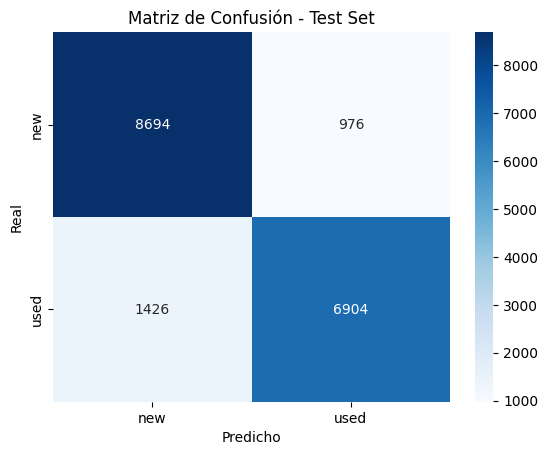


Reporte de Clasificación:
              precision    recall  f1-score   support

         new       0.86      0.90      0.88      9670
        used       0.88      0.83      0.85      8330

    accuracy                           0.87     18000
   macro avg       0.87      0.86      0.87     18000
weighted avg       0.87      0.87      0.87     18000


Modelo Base XGBoost entrenado y evaluado.


In [57]:
import xgboost as xgb
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix, classification_report
import matplotlib.pyplot as plt
import seaborn as sns

xgb_model = xgb.XGBClassifier(
    objective='binary:logistic',
    eval_metric='logloss',
    use_label_encoder=False,
    random_state=42
)

# Entrenamiento del modelo
xgb_model.fit(X_train, y_train)

# Predicción en Test Set
y_pred = xgb_model.predict(X_test)

# Evaluación de Métricas
accuracy = accuracy_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred, average='weighted')

# Reporte de Métricas
print("\nMétricas del Modelo Base:")
print(f"Accuracy en Test Set: {accuracy:.4f}")
print(f"F1-Score (Weighted): {f1:.4f}")

# Matriz de Confusión
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['new', 'used'], yticklabels=['new', 'used'])
plt.title('Matriz de Confusión - Test Set')
plt.xlabel('Predicho')
plt.ylabel('Real')
plt.show()

# Reporte Completo
print("\nReporte de Clasificación:")
print(classification_report(y_test, y_pred, target_names=['new', 'used']))

print("\nModelo Base XGBoost entrenado y evaluado.")


- Modelo seleccionado: XGBoostClassifier ➔ Por su robustez a outliers. Manejo adecuado de variables numericas, categoricas y sparsity. 

*Sparsity se refiere a datasets donde hay muchas columnas con la mayoría de sus valores en cero. XGBoost maneja eso sin problemas, por eso es ideal para features como los TF-IDF de títulos.
- División Train-Test ➔ 80%-20% con estratificación para mantener la distribución de clases.

- Métricas obtenidas en Test Set:

    - Accuracy: 0.8681 ➔ Superando el mínimo requerido (0.86).

    - F1-Score Weighted: 0.8678 ➔ Elegida como Secondary Metric para balancear precision y recall. Es útil en casos donde no es crítico solo predecir correctamente, sino también evitar confundir productos usados como nuevos (y viceversa).

- Matriz de Confusión:

    - Mejor desempeño en productos “new” (Recall 90%).

    - Leve margen de error en productos “used” (Recall 83%)


Este reporte muestra un modelo equilibrado, que mantiene un alto desempeño en ambas clases. Tiene una leve mejor capacidad para identificar productos ‘new’ (recall 90%) en comparación a ‘used’ (recall 83%), lo cual es esperable dado que ciertos productos usados pueden presentar características similares a nuevos. Sin embargo, la precisión en ambas clases es alta, lo que garantiza pocas clasificaciones erróneas. El F1-Score Weighted confirma que el modelo tiene un rendimiento robusto en términos de balance entre precision y recall.

# 7. Análisis de Feature Importance

- Obtiene la importancia de cada feature desde el modelo XGBoost entrenado.

- Ordena las features según su impacto en la toma de decisiones del modelo.

- Visualiza las Top 20 features más importantes en un gráfico de barras horizontal.

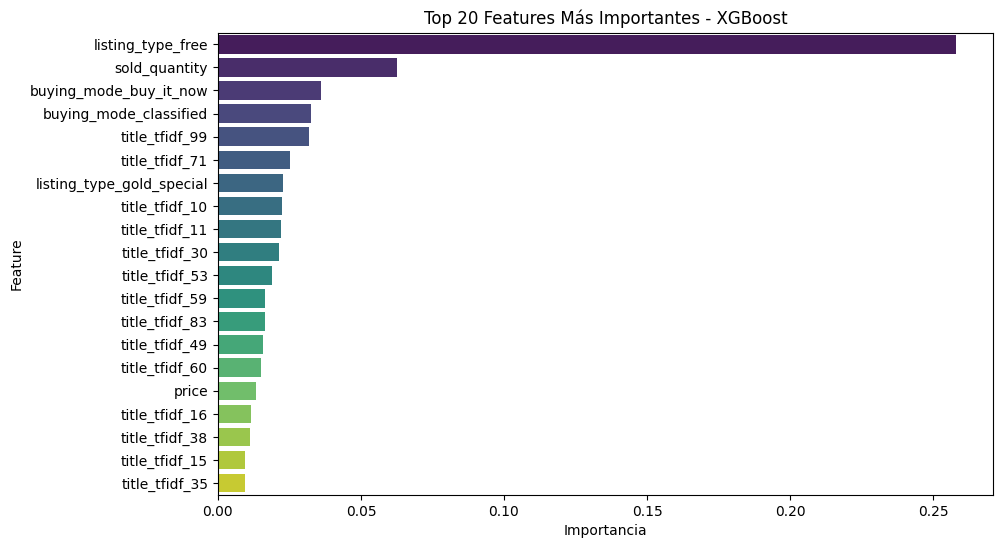

Análisis de Feature Importance completado.


,Feature,Importance
0,listing_type_free,0.258005
1,sold_quantity,0.062494
2,buying_mode_buy_it_now,0.036073
3,buying_mode_classified,0.032384
4,title_tfidf_99,0.031868
5,title_tfidf_71,0.025288
6,listing_type_gold_special,0.022810
7,title_tfidf_10,0.022562
8,title_tfidf_11,0.022088
9,title_tfidf_30,0.021392


In [63]:
# Obtener Importancia de las Features
feature_importances = pd.Series(xgb_model.feature_importances_, index=X_train.columns)
feature_importances = feature_importances.sort_values(ascending=False)

# Visualizar las Top 20 Features más Importantes
plt.figure(figsize=(10,6))
sns.barplot(x=feature_importances[:20], y=feature_importances[:20].index, hue=feature_importances[:20].index, palette='viridis', legend=False)
plt.title('Top 20 Features Más Importantes - XGBoost')
plt.xlabel('Importancia')
plt.ylabel('Feature')
plt.show()

# Exportar a DataFrame completo para revisión detallada
feature_importances_df = feature_importances.reset_index()
feature_importances_df.columns = ['Feature', 'Importance']

print("Análisis de Feature Importance completado.")
feature_importances_df.head(10)


Variables más relevantes:

- listing_type_free ➔ Fuerte indicador de “used”.

- buying_mode (classified & buy_it_now) ➔ Contextualizan formalidad de la publicación.

- sold_quantity ➔ Productos nuevos tienden a tener mayor volumen de ventas.

- TF-IDF Components del título ➔ Aportan semántica al modelo.

- El modelo no dependió de variables triviales (original_price, is_official_store), lo que indica buena capacidad de generalización.

El análisis de Feature Importance demuestra que el modelo está tomando decisiones basadas en variables de negocio coherentes, como el tipo de publicación, la modalidad de compra, y el volumen de ventas. Además, la inclusión de componentes semánticos del título (TF-IDF) permite capturar patrones textuales que complementan la clasificación. La importancia moderada de price confirma que el modelo considera esta variable en contexto, sin sobreajustarse. El modelo no depende de variables triviales como original_price, lo cual es un indicador de buena generalización.
